<a href="https://colab.research.google.com/github/akilawickey/IT-5437/blob/main/Assignment1_IT5437.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np, cv2, matplotlib.pyplot as plt, math, os
plt.rcParams['figure.dpi'] = 120

def read_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if bgr is None: raise FileNotFoundError(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def show(img, title="", gray=False, size=(4,4)):
    plt.figure(figsize=size)
    if gray: plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:    plt.imshow(img)
    plt.title(title); plt.axis('off'); plt.show()

def hist(img, title="Histogram"):
    plt.figure(figsize=(5,3))
    plt.hist(img.ravel(), bins=256, range=(0,255))
    plt.title(title); plt.xlabel("Intensity"); plt.ylabel("Count"); plt.show()

def apply_lut(img_u8, lut256):
    lut = np.asarray(lut256, dtype=np.uint8)
    return cv2.LUT(img_u8, lut)

def piecewise_lut(points):
    xs, ys = zip(*points)
    xs, ys = np.array(xs, float), np.array(ys, float)
    lut = np.zeros(256, float)
    i = 0
    while i < len(xs)-1:
        x0,y0,x1,y1 = xs[i],ys[i],xs[i+1],ys[i+1]
        if x1==x0:
            lut[int(x0)] = y0; i+=1; continue
        m = (y1-y0)/(x1-x0)
        xr = np.arange(int(np.ceil(x0)), int(np.floor(x1))+1)
        lut[xr] = m*(xr-x0)+y0
        i+=1
    lut[:int(xs[0])]  = ys[0]
    lut[int(xs[-1]):] = ys[-1]
    return np.clip(lut,0,255).astype(np.uint8)

def to_lab(rgb): return cv2.cvtColor(rgb, cv2.COLOR_RGB2LAB)
def to_rgb_from_lab(lab): return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
def to_hsv(rgb): return cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
def to_rgb_from_hsv(hsv): return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

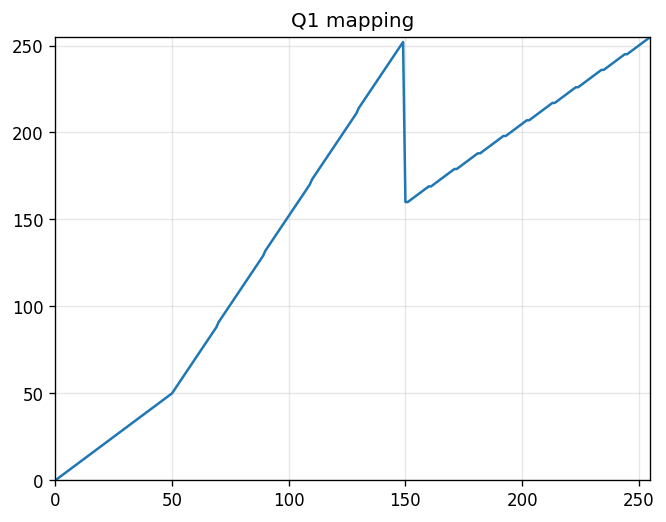

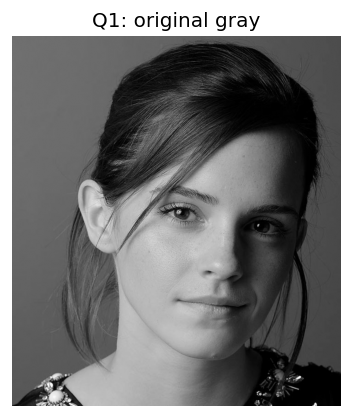

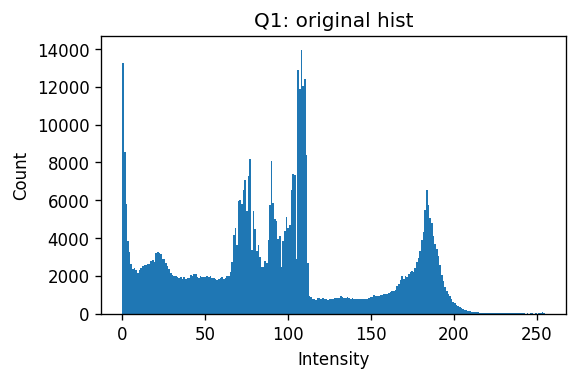

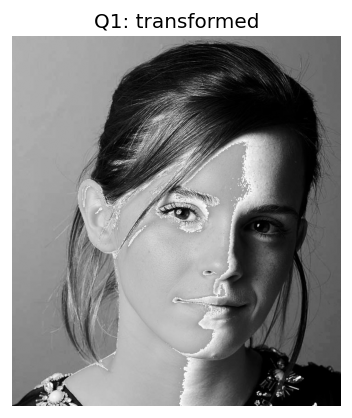

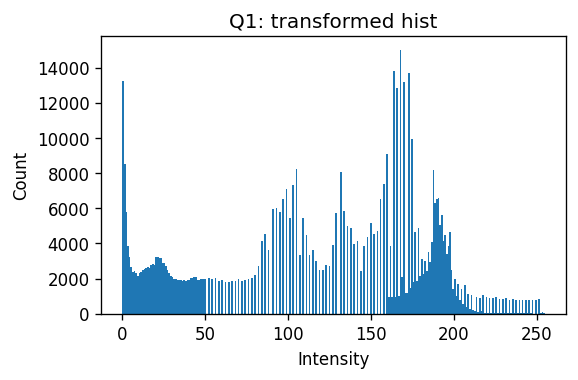

In [11]:
# Q1

# image file load
face_path = "/content/drive/MyDrive/cv images/emma.jpg"

rgb = read_rgb(face_path)
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)

# Points read from Fig.1(a): includes a deliberate jump at x=150
points = [(0,0), (50,50), (150,255), (150,160), (255,255)]
lut = piecewise_lut(points)

x = np.arange(256); plt.plot(x,lut); plt.title("Q1 mapping"); plt.xlim(0,255); plt.ylim(0,255); plt.grid(True,alpha=.3); plt.show()

out = apply_lut(gray, lut)
show(gray, "Q1: original gray", True); hist(gray, "Q1: original hist")
show(out,  "Q1: transformed", True);  hist(out,  "Q1: transformed hist")

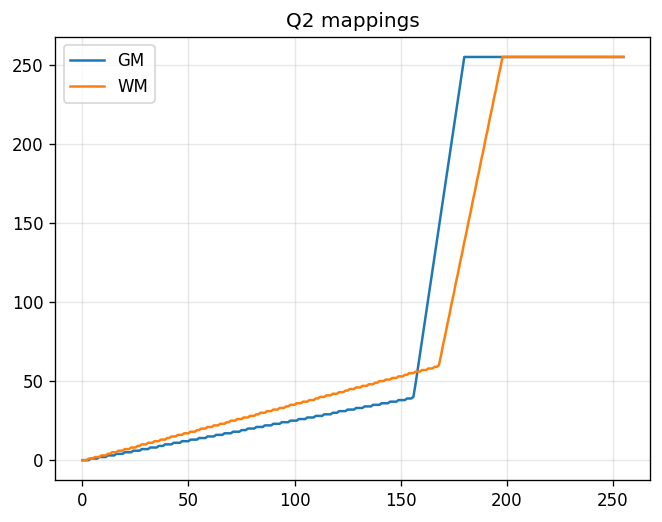

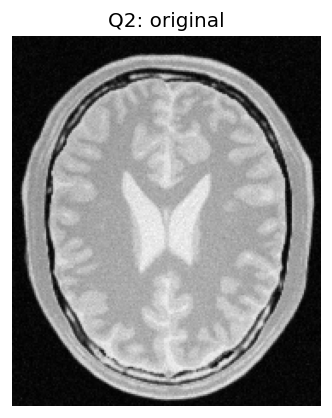

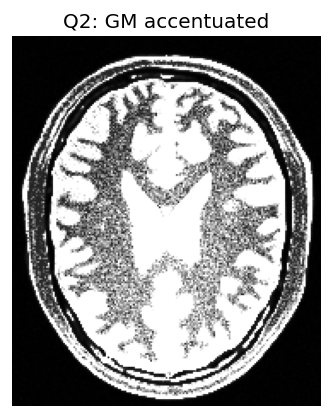

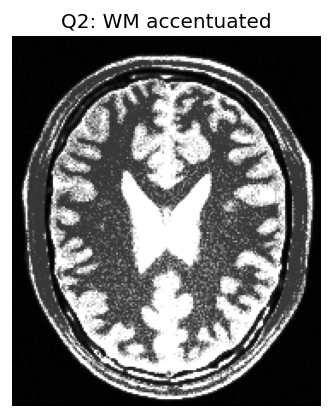

In [12]:
#Q2

brain_path = "/content/drive/MyDrive/cv images/brain_proton_density_slice.png"
brain = cv2.cvtColor(read_rgb(brain_path), cv2.COLOR_RGB2GRAY)
p = np.percentile(brain, [10,25,40,55,70,85,95])
p10,p25,p40,p55,p70,p85,p95 = p

# Heuristics: GM ~ mid; WM ~ higher-mid
G1,G2 = int(p40), int(p70)
W1,W2 = int(p55), int(p85)

gm_points = [(0,0),(G1,40),(G2,255),(255,255)]
wm_points = [(0,0),(W1,60),(W2,255),(255,255)]
lut_gm = piecewise_lut(gm_points)
lut_wm = piecewise_lut(wm_points)

plt.plot(np.arange(256), lut_gm, label="GM"); plt.plot(np.arange(256), lut_wm, label="WM")
plt.title("Q2 mappings"); plt.legend(); plt.grid(True,alpha=.3); plt.show()

brain_gm = apply_lut(brain, lut_gm)
brain_wm = apply_lut(brain, lut_wm)

show(brain, "Q2: original", True)
show(brain_gm, "Q2: GM accentuated", True)
show(brain_wm, "Q2: WM accentuated", True)

Q3 gamma (γ) = 0.544


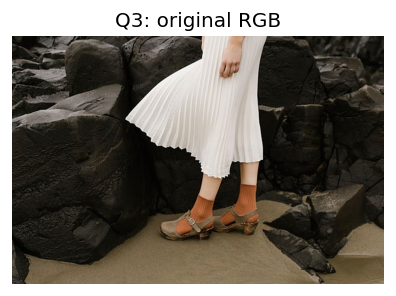

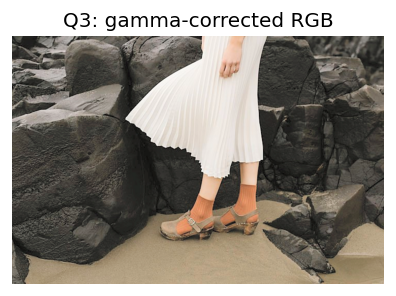

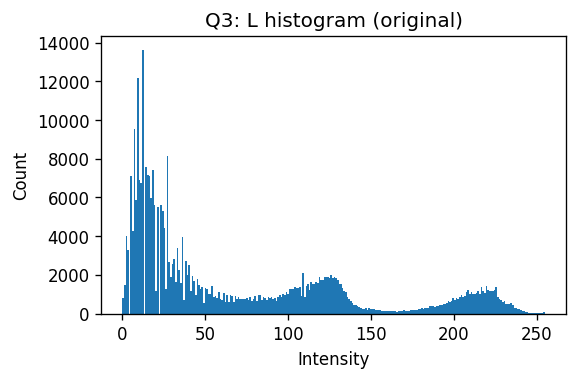

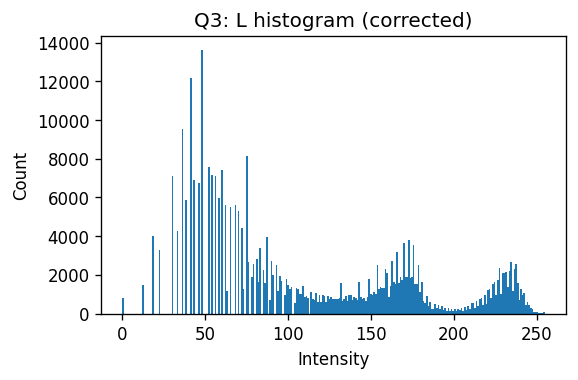

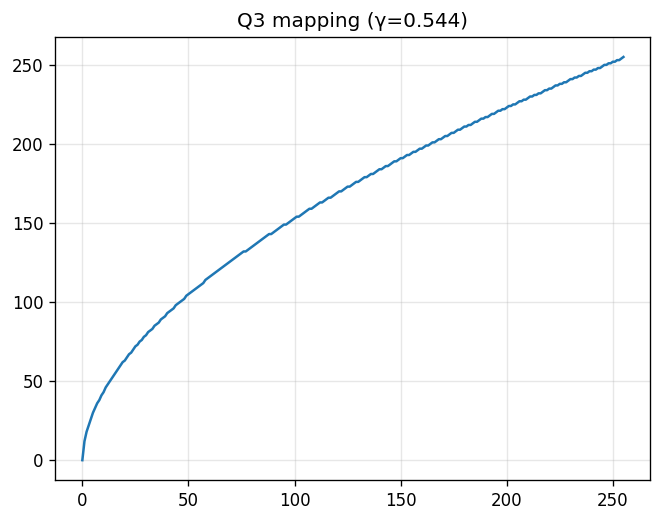

In [13]:
#Q3

q3_path = "/content/drive/MyDrive/cv images/highlights_and_shadows.jpg"

TARGET_MEAN = 0.50                       # set your target brightness of L
MANUAL_GAMMA = None                      # e.g., 0.8 or 1.2 to override

rgb = read_rgb(q3_path)
lab = to_lab(rgb); L,a,b = cv2.split(lab)
Ln = L.astype(np.float32)/255.0
mu = max(1e-6, float(Ln.mean()))
auto_gamma = math.log(TARGET_MEAN)/math.log(mu)
gamma = MANUAL_GAMMA if MANUAL_GAMMA is not None else auto_gamma

x = np.arange(256, dtype=np.float32)/255.0
lut = np.clip((x**gamma)*255.0, 0,255).astype(np.uint8)
L2 = apply_lut(L, lut)
rgb2 = to_rgb_from_lab(cv2.merge([L2,a,b]))

print(f"Q3 gamma (γ) = {gamma:.3f}")
show(rgb,  "Q3: original RGB")
show(rgb2, "Q3: gamma-corrected RGB")
hist(L,  "Q3: L histogram (original)")
hist(L2, "Q3: L histogram (corrected)")

plt.plot(np.arange(256), lut); plt.title(f"Q3 mapping (γ={gamma:.3f})"); plt.grid(True,alpha=.3); plt.show()


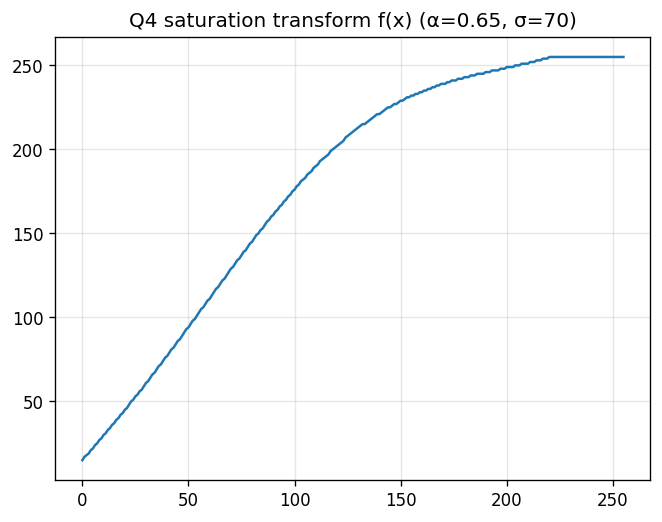

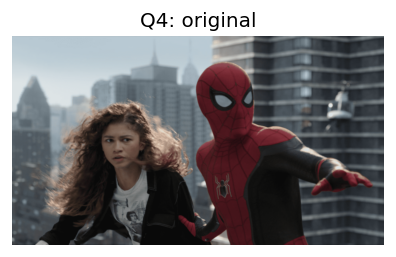

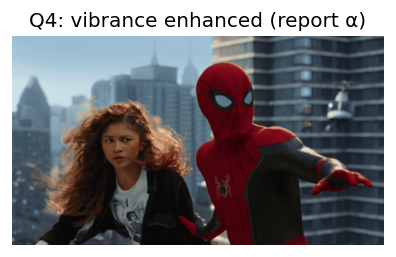

In [15]:
#Q4

q4_path = "/content/drive/MyDrive/cv images/spider.png"
ALPHA = 0.65

rgb = read_rgb(q4_path)
hsv = to_hsv(rgb); H,S,V = cv2.split(hsv)
x = np.arange(256, dtype=np.float32)
lut = np.minimum(x + ALPHA*128.0*np.exp(-((x-128.0)**2)/(2.0*(70.0**2))), 255.0).astype(np.uint8)

S2 = apply_lut(S, lut)
rgb_vib = to_rgb_from_hsv(cv2.merge([H,S2,V]))

plt.plot(np.arange(256), lut); plt.title(f"Q4 saturation transform f(x) (α={ALPHA}, σ=70)"); plt.grid(True,alpha=.3); plt.show()
show(rgb,     "Q4: original")
show(rgb_vib, "Q4: vibrance enhanced (report α)")

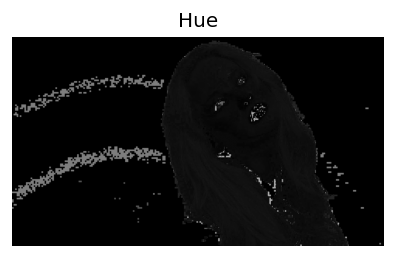

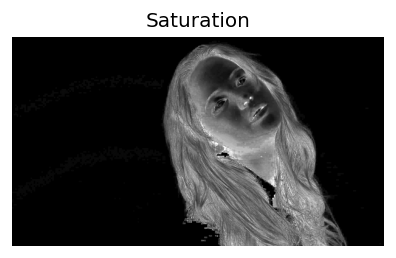

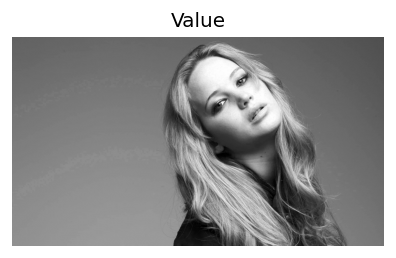

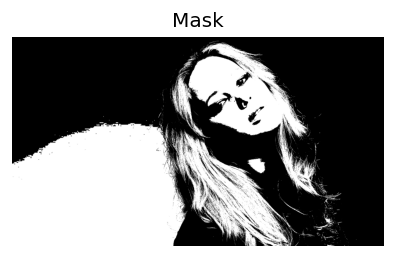

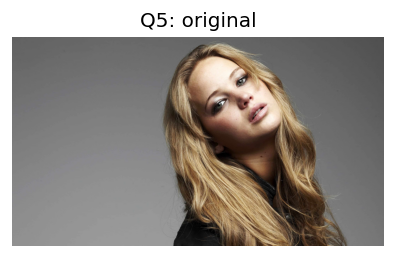

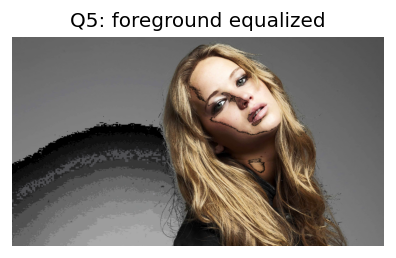

In [16]:
#Q5

q5_path = "/content/drive/MyDrive/cv images/jeniffer.jpg"
PLANE = "V"                               # "V" or "S"
FLIP_MASK = False                         # set True if subject is darker

rgb = read_rgb(q5_path)
hsv = to_hsv(rgb); H,S,V = cv2.split(hsv)
show(H, "Hue", True); show(S, "Saturation", True); show(V, "Value", True)

plane = V if PLANE=="V" else S
_, mask = cv2.threshold(plane, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
if FLIP_MASK: mask = cv2.bitwise_not(mask)
show(mask, "Mask", True)

# Foreground histogram & CDF on Value channel
vals = V[mask>0]
hist_fg = np.bincount(vals, minlength=256)
cdf = np.cumsum(hist_fg); N = int(cdf[-1]) if cdf[-1]>0 else 1
cdf_min = cdf[np.nonzero(cdf)][0] if np.any(hist_fg) else 0
lut = np.round(255.0*(cdf - cdf_min)/max(1,(N-cdf_min))).astype(np.uint8).clip(0,255)

V2 = V.copy(); V2[mask>0] = lut[V[mask>0]]
rgb_eq = to_rgb_from_hsv(cv2.merge([H,S,V2]))
show(rgb,    "Q5: original")
show(rgb_eq, "Q5: foreground equalized")


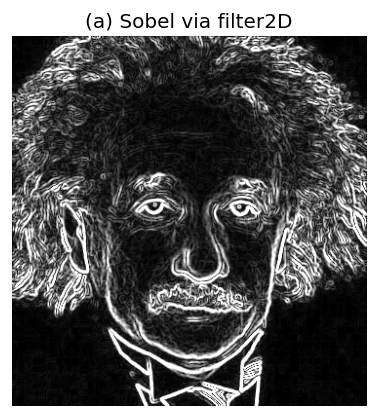

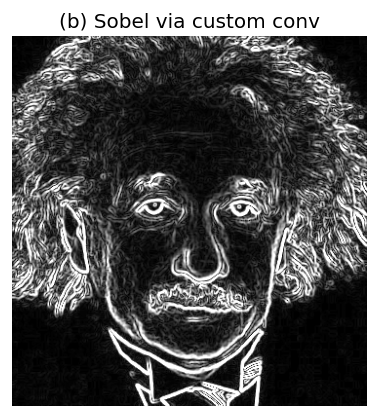

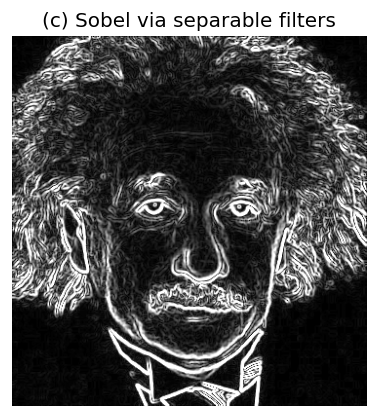

In [19]:
#Q6

q6_path = "/content/drive/MyDrive/cv images/einstein.png"

gray = cv2.cvtColor(read_rgb(q6_path), cv2.COLOR_RGB2GRAY)

# (a) Using filter2D with Sobel kernels
Kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], np.float32)
Ky = Kx.T
gx = cv2.filter2D(gray, cv2.CV_32F, Kx)
gy = cv2.filter2D(gray, cv2.CV_32F, Ky)
mag_a = cv2.convertScaleAbs(np.hypot(gx,gy))
show(mag_a, "(a) Sobel via filter2D", True)

# (b) Write your own convolution (valid padding by replication)
def conv2(img, k):
    pad = k.shape[0]//2
    imgp = cv2.copyMakeBorder(img, pad,pad,pad,pad, cv2.BORDER_REPLICATE)
    out = np.zeros_like(img, np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            out[i,j] = np.sum(imgp[i:i+k.shape[0], j:j+k.shape[1]] * k)
    return out
gx2 = conv2(gray.astype(np.float32), Kx)
gy2 = conv2(gray.astype(np.float32), Ky)
mag_b = cv2.convertScaleAbs(np.hypot(gx2,gy2))
show(mag_b, "(b) Sobel via custom conv", True)

# (c) Separable filtering: [[1],[2],[1]] * [1,0,-1]
v = np.array([[1],[2],[1]], np.float32)
h = np.array([[1,0,-1]],  np.float32)
gx3 = cv2.sepFilter2D(gray, cv2.CV_32F, h, v)  # (h then v)
gy3 = cv2.sepFilter2D(gray, cv2.CV_32F, v, h)  # (v then h)
mag_c = cv2.convertScaleAbs(np.hypot(gx3,gy3))
show(mag_c, "(c) Sobel via separable filters", True)
